In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_Paris_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_Paris_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_Paris_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [4]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

This section describes the creation of the LSTM model. Only the 'id,' 'date,' and 'price' columns are used here. The model then creates sequences of historical prices to learn temporal features that can contribute to predictive performance. The model is also hyperparameter-tuned using Optuna. Two additional variables that are tuned, besides the hyperparameters of the LSTM model itself, are 'sequence_length' and 'max_instances_per_location.'

The sequence length determines the size of the price sequences used to learn features. The max_instances_per_location parameter selects a certain number of random historical prices per unique location since using all historical prices would require too much computational power. The learned features are extracted, and the model is saved for later reuse. The max_instances_per_location is set to 100, as this has already been adjusted in the dataset, but it is kept in place just in case.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False, activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mse'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_PARIS_FINAL.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_FINAL.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_FINAL.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


The LSTM model can be reloaded here.


In [5]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_FINAL.pkl')

# Load the model

extraction_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = extraction_model.predict(X_train)
val_features_lstm = extraction_model.predict(X_val)
test_features_lstm = extraction_model.predict(X_test)



Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 317.28it/s]


14805/14805 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Here, the LSTM model can be reloaded to make price predictions.

In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_PARIS_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_FINAL.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
avg_residuals = np.mean(y_test_unscaled - y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)
print("Manual Calculation - Average Residuals:", avg_residuals)

Creating sequences: 100%|██████████| 2000/2000 [00:08<00:00, 235.90it/s]


1186/1186 - 8s - 7ms/step - loss: 0.0318 - mean_squared_error: 0.0318
1186/1186 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
Evaluation - Loss, MSE, MAE: [0.03177676349878311, 0.03177676349878311]
Manual Calculation - Mean Squared Error (MSE): 224.21691473142113
Manual Calculation - Mean Absolute Error (MAE): 2.722197154347323
Manual Calculation - R-squared: 0.9906338785301937
Manual Calculation - Average Residuals: 0.603764687707951


In [ ]:
# Unscaling the datasets
train_data_lstm_unscaled = train_data_lstm.copy()
train_data_lstm_unscaled['price'] = scaler.inverse_transform(train_data_lstm[['price']])

val_data_lstm_unscaled = val_data_lstm.copy()
val_data_lstm_unscaled['price'] = scaler.inverse_transform(val_data_lstm[['price']])

test_data_lstm_unscaled = test_data_lstm.copy()
test_data_lstm_unscaled['price'] = scaler.inverse_transform(test_data_lstm[['price']])




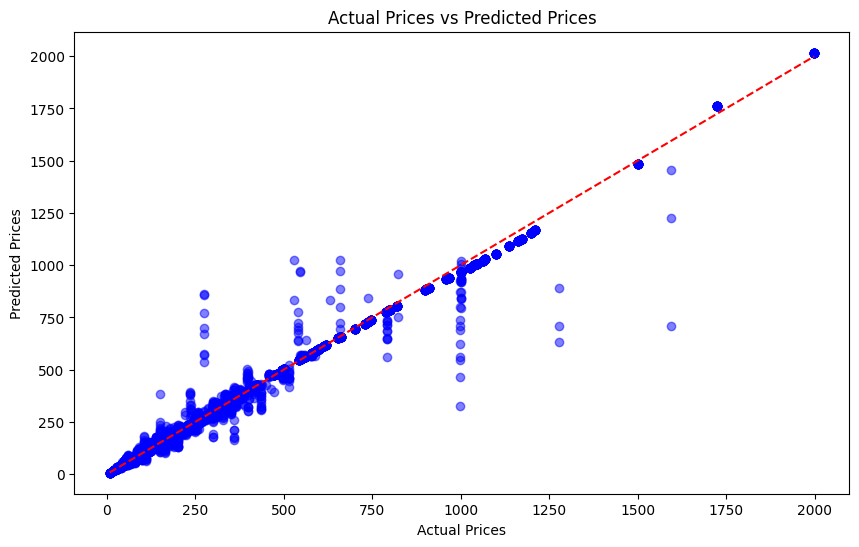

In [ ]:
# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, color='blue', alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')

plt.show()

Code to correctly merge the LSTM features with the original data.

In [31]:
train_features_lstm = scaler.inverse_transform(train_features_lstm)
val_features_lstm = scaler.inverse_transform(val_features_lstm)
test_features_lstm = scaler.inverse_transform(test_features_lstm)

In [32]:
# Convert the extracted features and IDs into DataFrames with clean integer IDs
train_features_with_ids = pd.DataFrame(train_features_lstm)
train_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_ids]

val_features_with_ids = pd.DataFrame(val_features_lstm)
val_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_ids]

test_features_with_ids = pd.DataFrame(test_features_lstm)
test_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features and their associated integer IDs


In [33]:
# Extract the last occurrence of each ID's features
def extract_last_features(features, ids):
    last_features_map = {}
    for idx, id in enumerate(ids):
        last_features_map[id] = features[idx]
    unique_ids = list(last_features_map.keys())
    last_features = np.array([last_features_map[id] for id in unique_ids])
    return last_features, unique_ids

# Apply extraction of the last features
train_last_features, train_unique_ids = extract_last_features(train_features_lstm, train_ids)
val_last_features, val_unique_ids = extract_last_features(val_features_lstm, val_ids)
test_last_features, test_unique_ids = extract_last_features(test_features_lstm, test_ids)

# Convert to DataFrames
train_features_with_ids_last = pd.DataFrame(train_last_features)
train_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_unique_ids]

val_features_with_ids_last = pd.DataFrame(val_last_features)
val_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_unique_ids]

test_features_with_ids_last = pd.DataFrame(test_last_features)
test_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_unique_ids]

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [34]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [35]:

import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [36]:
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id',
    #'weekday', 'month', 'day',
    'is_holiday', 'is_school_holiday', 'season_Autumn', 'season_Winter', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée',
    #'Eiffel Tower Distance', 'Louvre Museum Distance', 'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


<ipython-input-36-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-36-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-36-37cdb7c6f7a2>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [37]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,6,7,8,9,10,11,12,13,14,15
0,0.0,0.654762,1.5,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.691853,-0.890923,-0.682969,-0.965055,53.193115,-0.761051,2.653020,-0.833573,15.182281,-7.420529
1,0.0,0.535714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.583905,-0.536125,-0.533809,-0.540988,-0.281984,-0.540219,-0.542791,-0.540672,0.308866,1.535035
2,1.0,-0.238095,0.0,0.0,1.0,3.0,0.0,-0.5,0.0,0.0,...,-0.312861,0.234235,0.245233,0.234241,-0.062028,0.244304,0.161835,0.236230,0.113289,-0.048030
3,0.0,0.059524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.129822,-0.059183,-0.060389,-0.059664,0.337951,-0.061009,-0.155144,-0.059398,-0.161146,0.528695
4,1.0,0.583333,1.5,1.0,3.0,25.0,0.0,1.0,0.5,0.0,...,0.614994,-0.580954,-0.578769,-0.586692,-0.538443,-0.584885,-0.607951,-0.586860,0.482948,1.573422


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_paris_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_paris_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_paris_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 15:28:38,643] A new study created in memory with name: no-name-850bdb23-6c86-42b4-a5c9-68a37195a1d2
Training PEGNN: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it]
[I 2024-08-13 15:30:44,874] Trial 0 finished with value: 3.2853615283966064 and parameters: {'hidden_channels': 43, 'lr': 0.00010996384649747142, 'k': 142, 'dropout_rate': 0.17139340081610527}. Best is trial 0 with value: 3.2853615283966064.
Training PEGNN: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]
[I 2024-08-13 15:31:12,745] Trial 1 finished with value: 0.21951818466186523 and parameters: {'hidden_channels': 112, 'lr': 0.0003321514428632553, 'k': 26, 'dropout_rate': 0.4599246049817415}. Best is trial 1 with value: 0.21951818466186523.
Training PEGNN: 100%|██████████| 50/50 [01:51<00:00,  2.24s/it]
[I 2024-08-13 15:33:07,062] Trial 2 finished with value: 0.1582234650850296 and parameters: {'hidden_channels': 38, 'lr': 0.002615664159074822, 'k': 135, 'dropout_rate': 0.12156679922236822}. Best is trial 2 wi

Best parameters:  {'hidden_channels': 60, 'lr': 0.004125690472938597, 'k': 76, 'dropout_rate': 0.21703431446963561}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 3.267512321472168, Training R-squared: -0.11044638504811743, Training MAE: 0.818389892578125, Training MSE: 3.267512321472168
Epoch 1, Validation Loss: 2.989816665649414, Validation R-squared: 0.2154492271419769, Validation MAE: 0.7491782307624817, Validation MSE: 2.989816904067993


Final training:   0%|          | 2/500 [00:03<13:01,  1.57s/it]

Epoch 2, Training Loss: 2.371407985687256, Training R-squared: 0.1940898670775515, Training MAE: 0.7272243499755859, Training MSE: 2.3714077472686768
Epoch 2, Validation Loss: 2.182244300842285, Validation R-squared: 0.42736242071200925, Validation MAE: 0.8071405291557312, Validation MSE: 2.182244300842285
Epoch 3, Training Loss: 1.784925103187561, Training R-squared: 0.39340283043855484, Training MAE: 0.7769353985786438, Training MSE: 1.784925103187561


Final training:   1%|          | 3/500 [00:04<13:03,  1.58s/it]

Epoch 3, Validation Loss: 1.7391759157180786, Validation R-squared: 0.5436269722305211, Validation MAE: 0.8819276094436646, Validation MSE: 1.7391759157180786
Epoch 4, Training Loss: 1.5183278322219849, Training R-squared: 0.4840045428292292, Training MAE: 0.8539910316467285, Training MSE: 1.5183278322219849
Epoch 4, Validation Loss: 1.2558488845825195, Validation R-squared: 0.6704556473923322, Validation MAE: 0.7920566201210022, Validation MSE: 1.2558488845825195


Final training:   1%|          | 5/500 [00:07<13:03,  1.58s/it]

Epoch 5, Training Loss: 1.1767051219940186, Training R-squared: 0.6001031183660934, Training MAE: 0.7763487100601196, Training MSE: 1.176705241203308
Epoch 5, Validation Loss: 0.7804390788078308, Validation R-squared: 0.7952068143242758, Validation MAE: 0.6117787957191467, Validation MSE: 0.7804390788078308


Final training:   1%|          | 6/500 [00:09<12:58,  1.58s/it]

Epoch 6, Training Loss: 0.8574590682983398, Training R-squared: 0.7085971914476816, Training MAE: 0.6263835430145264, Training MSE: 0.8574590086936951
Epoch 6, Validation Loss: 0.45046737790107727, Validation R-squared: 0.8817939262547837, Validation MAE: 0.42993199825286865, Validation MSE: 0.45046737790107727


Final training:   1%|▏         | 7/500 [00:11<12:51,  1.57s/it]

Epoch 7, Training Loss: 0.5818963050842285, Training R-squared: 0.8022456819042425, Training MAE: 0.4651075005531311, Training MSE: 0.5818963050842285
Epoch 7, Validation Loss: 0.30651745200157166, Validation R-squared: 0.9195674792747777, Validation MAE: 0.32338500022888184, Validation MSE: 0.30651745200157166


Final training:   2%|▏         | 8/500 [00:12<12:47,  1.56s/it]

Epoch 8, Training Loss: 0.48034894466400146, Training R-squared: 0.8367560085006325, Training MAE: 0.37332722544670105, Training MSE: 0.48034894466400146
Epoch 8, Validation Loss: 0.2949853837490082, Validation R-squared: 0.9225935839815969, Validation MAE: 0.31511205434799194, Validation MSE: 0.2949853539466858


Final training:   2%|▏         | 9/500 [00:14<12:46,  1.56s/it]

Epoch 9, Training Loss: 0.42198148369789124, Training R-squared: 0.8565918786700836, Training MAE: 0.36597752571105957, Training MSE: 0.42198148369789124
Epoch 9, Validation Loss: 0.32365626096725464, Validation R-squared: 0.9150701311628222, Validation MAE: 0.33666494488716125, Validation MSE: 0.32365626096725464


Final training:   2%|▏         | 10/500 [00:15<12:40,  1.55s/it]

Epoch 10, Training Loss: 0.49114087224006653, Training R-squared: 0.8330884222005275, Training MAE: 0.39052316546440125, Training MSE: 0.49114087224006653
Epoch 10, Validation Loss: 0.3581429421901703, Validation R-squared: 0.9060205541252787, Validation MAE: 0.35697516798973083, Validation MSE: 0.3581429421901703
Epoch 11, Training Loss: 0.49048087000846863, Training R-squared: 0.8333127291372677, Training MAE: 0.4030015170574188, Training MSE: 0.49048084020614624


Final training:   2%|▏         | 11/500 [00:17<12:52,  1.58s/it]

Epoch 11, Validation Loss: 0.38131198287010193, Validation R-squared: 0.8999408146820632, Validation MAE: 0.36501333117485046, Validation MSE: 0.3813120126724243
Epoch 12, Training Loss: 0.48718881607055664, Training R-squared: 0.8344315082442606, Training MAE: 0.40457355976104736, Training MSE: 0.48718881607055664


Final training:   2%|▏         | 12/500 [00:18<13:02,  1.60s/it]

Epoch 12, Validation Loss: 0.3869773745536804, Validation R-squared: 0.898454176771667, Validation MAE: 0.35673511028289795, Validation MSE: 0.3869773745536804


Final training:   3%|▎         | 13/500 [00:20<13:02,  1.61s/it]

Epoch 13, Training Loss: 0.4649280905723572, Training R-squared: 0.8419967095788998, Training MAE: 0.3926619589328766, Training MSE: 0.4649280607700348
Epoch 13, Validation Loss: 0.38064199686050415, Validation R-squared: 0.9001166343654783, Validation MAE: 0.33446571230888367, Validation MSE: 0.38064196705818176


Final training:   3%|▎         | 14/500 [00:22<12:53,  1.59s/it]

Epoch 14, Training Loss: 0.4216453433036804, Training R-squared: 0.8567061087347942, Training MAE: 0.3735075294971466, Training MSE: 0.4216453433036804
Epoch 14, Validation Loss: 0.36799901723861694, Validation R-squared: 0.9034342477722787, Validation MAE: 0.3053792715072632, Validation MSE: 0.36799901723861694


Final training:   3%|▎         | 15/500 [00:23<12:49,  1.59s/it]

Epoch 15, Training Loss: 0.39688190817832947, Training R-squared: 0.8651218197526236, Training MAE: 0.34819212555885315, Training MSE: 0.39688196778297424
Epoch 15, Validation Loss: 0.36361804604530334, Validation R-squared: 0.9045838585797813, Validation MAE: 0.28181102871894836, Validation MSE: 0.36361798644065857


Final training:   3%|▎         | 16/500 [00:25<12:42,  1.57s/it]

Epoch 16, Training Loss: 0.39097240567207336, Training R-squared: 0.8671301305990617, Training MAE: 0.3310142457485199, Training MSE: 0.39097240567207336
Epoch 16, Validation Loss: 0.36375904083251953, Validation R-squared: 0.9045468519647624, Validation MAE: 0.27316319942474365, Validation MSE: 0.36375904083251953


Final training:   3%|▎         | 17/500 [00:26<12:32,  1.56s/it]

Epoch 17, Training Loss: 0.4101003408432007, Training R-squared: 0.8606296272375883, Training MAE: 0.3386040925979614, Training MSE: 0.4101003408432007
Epoch 17, Validation Loss: 0.337602436542511, Validation R-squared: 0.9114105375209338, Validation MAE: 0.26194071769714355, Validation MSE: 0.337602436542511


Final training:   4%|▎         | 18/500 [00:28<12:25,  1.55s/it]

Epoch 18, Training Loss: 0.3893657624721527, Training R-squared: 0.8676761429397337, Training MAE: 0.336212694644928, Training MSE: 0.3893657922744751
Epoch 18, Validation Loss: 0.2995545268058777, Validation R-squared: 0.9213945992680159, Validation MAE: 0.23295196890830994, Validation MSE: 0.2995545268058777
Epoch 19, Training Loss: 0.3464726209640503, Training R-squared: 0.8822531451648469, Training MAE: 0.31511807441711426, Training MSE: 0.3464726507663727


Final training:   4%|▍         | 19/500 [00:29<12:29,  1.56s/it]

Epoch 19, Validation Loss: 0.28409039974212646, Validation R-squared: 0.9254525175127107, Validation MAE: 0.20285752415657043, Validation MSE: 0.2840903401374817
Epoch 20, Training Loss: 0.3346884846687317, Training R-squared: 0.8862579268633747, Training MAE: 0.2881556749343872, Training MSE: 0.3346884846687317


Final training:   4%|▍         | 20/500 [00:31<12:38,  1.58s/it]

Epoch 20, Validation Loss: 0.27517974376678467, Validation R-squared: 0.9277907391917292, Validation MAE: 0.1827838122844696, Validation MSE: 0.2751797139644623


Final training:   4%|▍         | 21/500 [00:33<12:43,  1.59s/it]

Epoch 21, Training Loss: 0.34781140089035034, Training R-squared: 0.8817981777878248, Training MAE: 0.2720188498497009, Training MSE: 0.34781140089035034
Epoch 21, Validation Loss: 0.2601378858089447, Validation R-squared: 0.931737839033295, Validation MAE: 0.17286670207977295, Validation MSE: 0.2601378560066223


Final training:   4%|▍         | 22/500 [00:34<12:38,  1.59s/it]

Epoch 22, Training Loss: 0.35906243324279785, Training R-squared: 0.8779745877759288, Training MAE: 0.27219438552856445, Training MSE: 0.3590623736381531
Epoch 22, Validation Loss: 0.23217132687568665, Validation R-squared: 0.9390764698720657, Validation MAE: 0.16338153183460236, Validation MSE: 0.23217132687568665
Epoch 23, Training Loss: 0.3050971031188965, Training R-squared: 0.8963144040163069, Training MAE: 0.2693326473236084, Training MSE: 0.3050970733165741
Epoch 23, Validation Loss: 0.2150079309940338, Validation R-squared: 0.9435802735383412, Validation MAE: 0.16665196418762207, Validation MSE: 0.2150079309940338


Final training:   5%|▍         | 24/500 [00:37<12:31,  1.58s/it]

Epoch 24, Training Loss: 0.2653839886188507, Training R-squared: 0.9098106873151869, Training MAE: 0.2698551416397095, Training MSE: 0.2653839886188507
Epoch 24, Validation Loss: 0.21550855040550232, Validation R-squared: 0.9434489113484723, Validation MAE: 0.17992058396339417, Validation MSE: 0.21550855040550232


Final training:   5%|▌         | 25/500 [00:39<12:25,  1.57s/it]

Epoch 25, Training Loss: 0.29530787467956543, Training R-squared: 0.8996412166151072, Training MAE: 0.2821051776409149, Training MSE: 0.29530787467956543
Epoch 25, Validation Loss: 0.20645810663700104, Validation R-squared: 0.9458238144060821, Validation MAE: 0.17086590826511383, Validation MSE: 0.20645812153816223


Final training:   5%|▌         | 26/500 [00:40<12:23,  1.57s/it]

Epoch 26, Training Loss: 0.30508139729499817, Training R-squared: 0.896319739930174, Training MAE: 0.2748415470123291, Training MSE: 0.30508139729499817
Epoch 26, Validation Loss: 0.1815667450428009, Validation R-squared: 0.9523555002313315, Validation MAE: 0.1423051357269287, Validation MSE: 0.1815667450428009


Final training:   5%|▌         | 27/500 [00:42<12:24,  1.57s/it]

Epoch 27, Training Loss: 0.2913926839828491, Training R-squared: 0.9009717742027615, Training MAE: 0.25849494338035583, Training MSE: 0.2913927137851715
Epoch 27, Validation Loss: 0.16918623447418213, Validation R-squared: 0.9556042414157003, Validation MAE: 0.12981437146663666, Validation MSE: 0.16918623447418213
Epoch 28, Training Loss: 0.27435967326164246, Training R-squared: 0.9067603473819986, Training MAE: 0.24467505514621735, Training MSE: 0.27435967326164246


Final training:   6%|▌         | 28/500 [00:44<12:27,  1.58s/it]

Epoch 28, Validation Loss: 0.16975288093090057, Validation R-squared: 0.9554555450887808, Validation MAE: 0.13767166435718536, Validation MSE: 0.16975288093090057


Final training:   6%|▌         | 29/500 [00:45<12:30,  1.59s/it]

Epoch 29, Training Loss: 0.2385866492986679, Training R-squared: 0.9189176230143397, Training MAE: 0.23602132499217987, Training MSE: 0.2385866343975067
Epoch 29, Validation Loss: 0.1687893569469452, Validation R-squared: 0.9557083885910164, Validation MAE: 0.14825956523418427, Validation MSE: 0.168789342045784


Final training:   6%|▌         | 30/500 [00:47<12:23,  1.58s/it]

Epoch 30, Training Loss: 0.2619610130786896, Training R-squared: 0.9109739587358653, Training MAE: 0.24015478789806366, Training MSE: 0.26196104288101196
Epoch 30, Validation Loss: 0.16474686563014984, Validation R-squared: 0.9567691630338603, Validation MAE: 0.15478895604610443, Validation MSE: 0.16474688053131104


Final training:   6%|▌         | 31/500 [00:48<12:21,  1.58s/it]

Epoch 31, Training Loss: 0.2327418476343155, Training R-squared: 0.9209039517289408, Training MAE: 0.23623433709144592, Training MSE: 0.2327418178319931
Epoch 31, Validation Loss: 0.16610264778137207, Validation R-squared: 0.9564133964604132, Validation MAE: 0.16033005714416504, Validation MSE: 0.16610264778137207


Final training:   6%|▋         | 32/500 [00:50<12:14,  1.57s/it]

Epoch 32, Training Loss: 0.252126008272171, Training R-squared: 0.9143163305761491, Training MAE: 0.24777056276798248, Training MSE: 0.2521260380744934
Epoch 32, Validation Loss: 0.17237286269664764, Validation R-squared: 0.954768042451229, Validation MAE: 0.16151393949985504, Validation MSE: 0.17237286269664764


Final training:   7%|▋         | 33/500 [00:51<12:08,  1.56s/it]

Epoch 33, Training Loss: 0.20799429714679718, Training R-squared: 0.929314268854217, Training MAE: 0.23863446712493896, Training MSE: 0.207994282245636
Epoch 33, Validation Loss: 0.17399105429649353, Validation R-squared: 0.9543434144764635, Validation MAE: 0.15417064726352692, Validation MSE: 0.17399105429649353


Final training:   7%|▋         | 34/500 [00:53<12:06,  1.56s/it]

Epoch 34, Training Loss: 0.2167939990758896, Training R-squared: 0.9263237257145739, Training MAE: 0.23142977058887482, Training MSE: 0.21679402887821198
Epoch 34, Validation Loss: 0.1634349822998047, Validation R-squared: 0.9571134097694802, Validation MAE: 0.1442844271659851, Validation MSE: 0.1634349822998047
Epoch 35, Training Loss: 0.2172684669494629, Training R-squared: 0.9261624886015587, Training MAE: 0.21895530819892883, Training MSE: 0.2172684669494629
Epoch 35, Validation Loss: 0.16068150103092194, Validation R-squared: 0.9578359475408512, Validation MAE: 0.14575053751468658, Validation MSE: 0.16068151593208313


Final training:   7%|▋         | 36/500 [00:56<12:10,  1.57s/it]

Epoch 36, Training Loss: 0.215560644865036, Training R-squared: 0.926742875486824, Training MAE: 0.21665999293327332, Training MSE: 0.2155606746673584
Epoch 36, Validation Loss: 0.16780124604701996, Validation R-squared: 0.9559676709608134, Validation MAE: 0.15297064185142517, Validation MSE: 0.16780126094818115


Final training:   7%|▋         | 37/500 [00:58<12:10,  1.58s/it]

Epoch 37, Training Loss: 0.20937253534793854, Training R-squared: 0.9288458735980846, Training MAE: 0.22020794451236725, Training MSE: 0.20937253534793854
Epoch 37, Validation Loss: 0.16443505883216858, Validation R-squared: 0.9568509838920916, Validation MAE: 0.1450696587562561, Validation MSE: 0.16443505883216858


Final training:   8%|▊         | 38/500 [00:59<12:09,  1.58s/it]

Epoch 38, Training Loss: 0.23733572661876678, Training R-squared: 0.9193427338799864, Training MAE: 0.2159176468849182, Training MSE: 0.23733572661876678
Epoch 38, Validation Loss: 0.15667377412319183, Validation R-squared: 0.9588876043886662, Validation MAE: 0.12552417814731598, Validation MSE: 0.15667378902435303
Epoch 39, Training Loss: 0.20838488638401031, Training R-squared: 0.9291815248283735, Training MAE: 0.20309989154338837, Training MSE: 0.20838488638401031
Epoch 39, Validation Loss: 0.14418067038059235, Validation R-squared: 0.9621658889394011, Validation MAE: 0.10663281381130219, Validation MSE: 0.14418067038059235


Final training:   8%|▊         | 40/500 [01:02<12:02,  1.57s/it]

Epoch 40, Training Loss: 0.20101800560951233, Training R-squared: 0.9316851222694752, Training MAE: 0.2021118700504303, Training MSE: 0.20101799070835114
Epoch 40, Validation Loss: 0.14193332195281982, Validation R-squared: 0.9627556131496154, Validation MAE: 0.10907883942127228, Validation MSE: 0.14193332195281982
Epoch 41, Training Loss: 0.19813431799411774, Training R-squared: 0.9326651210179453, Training MAE: 0.21185949444770813, Training MSE: 0.19813433289527893
Epoch 41, Validation Loss: 0.13979436457157135, Validation R-squared: 0.9633168931913854, Validation MAE: 0.11125344783067703, Validation MSE: 0.13979433476924896


Final training:   8%|▊         | 41/500 [01:04<12:01,  1.57s/it]

Epoch 42, Training Loss: 0.20521120727062225, Training R-squared: 0.9302600879807476, Training MAE: 0.21701741218566895, Training MSE: 0.20521117746829987
Epoch 42, Validation Loss: 0.13374492526054382, Validation R-squared: 0.9649043105962954, Validation MAE: 0.10274951159954071, Validation MSE: 0.13374494016170502


Final training:   9%|▊         | 43/500 [01:07<11:54,  1.56s/it]

Epoch 43, Training Loss: 0.18848612904548645, Training R-squared: 0.9359440140542825, Training MAE: 0.20844708383083344, Training MSE: 0.18848612904548645
Epoch 43, Validation Loss: 0.13141869008541107, Validation R-squared: 0.9655147316238164, Validation MAE: 0.10537759959697723, Validation MSE: 0.13141870498657227
Epoch 44, Training Loss: 0.18522052466869354, Training R-squared: 0.9370538107157207, Training MAE: 0.1958107054233551, Training MSE: 0.18522052466869354
Epoch 44, Validation Loss: 0.13110657036304474, Validation R-squared: 0.9655966322376335, Validation MAE: 0.11809411644935608, Validation MSE: 0.13110658526420593


Final training:   9%|▉         | 44/500 [01:09<12:01,  1.58s/it]

Epoch 45, Training Loss: 0.16921116411685944, Training R-squared: 0.9424945015691537, Training MAE: 0.19306477904319763, Training MSE: 0.16921116411685944
Epoch 45, Validation Loss: 0.12311992049217224, Validation R-squared: 0.9676923937245407, Validation MAE: 0.1176324412226677, Validation MSE: 0.12311990559101105


Final training:   9%|▉         | 45/500 [01:10<12:03,  1.59s/it]

Epoch 46, Training Loss: 0.17272597551345825, Training R-squared: 0.9413000133676271, Training MAE: 0.19157597422599792, Training MSE: 0.17272597551345825
Epoch 46, Validation Loss: 0.11941972374916077, Validation R-squared: 0.9686633521272989, Validation MAE: 0.11360695213079453, Validation MSE: 0.11941972374916077


Final training:   9%|▉         | 47/500 [01:14<11:51,  1.57s/it]

Epoch 47, Training Loss: 0.21258579194545746, Training R-squared: 0.9277538691011651, Training MAE: 0.19544315338134766, Training MSE: 0.21258579194545746
Epoch 47, Validation Loss: 0.11339583992958069, Validation R-squared: 0.970244064045258, Validation MAE: 0.10573964565992355, Validation MSE: 0.11339583247900009


Final training:  10%|▉         | 48/500 [01:15<11:44,  1.56s/it]

Epoch 48, Training Loss: 0.18739904463291168, Training R-squared: 0.9363134434070108, Training MAE: 0.18820923566818237, Training MSE: 0.18739904463291168
Epoch 48, Validation Loss: 0.11180828511714935, Validation R-squared: 0.970660650474353, Validation MAE: 0.1025797575712204, Validation MSE: 0.11180827021598816


Final training:  10%|▉         | 49/500 [01:17<11:39,  1.55s/it]

Epoch 49, Training Loss: 0.20864689350128174, Training R-squared: 0.9290924816952801, Training MAE: 0.18795758485794067, Training MSE: 0.20864689350128174
Epoch 49, Validation Loss: 0.11349580436944962, Validation R-squared: 0.9702178343283431, Validation MAE: 0.10439363121986389, Validation MSE: 0.11349581927061081


Final training:  10%|█         | 50/500 [01:18<11:44,  1.57s/it]

Epoch 50, Training Loss: 0.19247865676879883, Training R-squared: 0.9345871707007274, Training MAE: 0.18474668264389038, Training MSE: 0.19247864186763763
Epoch 50, Validation Loss: 0.11690703779459, Validation R-squared: 0.9693227023950827, Validation MAE: 0.10703631490468979, Validation MSE: 0.1169070303440094


Final training:  10%|█         | 51/500 [01:20<11:42,  1.56s/it]

Epoch 51, Training Loss: 0.1940288245677948, Training R-squared: 0.9340603518166231, Training MAE: 0.18895135819911957, Training MSE: 0.1940288245677948
Epoch 51, Validation Loss: 0.11873213201761246, Validation R-squared: 0.9688437813196984, Validation MAE: 0.10567846894264221, Validation MSE: 0.11873213201761246


Final training:  10%|█         | 52/500 [01:21<11:42,  1.57s/it]

Epoch 52, Training Loss: 0.1870449185371399, Training R-squared: 0.936433788973484, Training MAE: 0.19002799689769745, Training MSE: 0.18704494833946228
Epoch 52, Validation Loss: 0.11926250904798508, Validation R-squared: 0.9687046008782418, Validation MAE: 0.10225656628608704, Validation MSE: 0.11926253139972687
Epoch 53, Training Loss: 0.18716733157634735, Training R-squared: 0.9363921909241882, Training MAE: 0.18921056389808655, Training MSE: 0.18716736137866974


Final training:  11%|█         | 53/500 [01:23<11:49,  1.59s/it]

Epoch 53, Validation Loss: 0.12691153585910797, Validation R-squared: 0.9666974486405171, Validation MAE: 0.1037817895412445, Validation MSE: 0.12691152095794678


Final training:  11%|█         | 54/500 [01:25<11:43,  1.58s/it]

Epoch 54, Training Loss: 0.18196839094161987, Training R-squared: 0.9381590309640033, Training MAE: 0.18439701199531555, Training MSE: 0.18196839094161987
Epoch 54, Validation Loss: 0.13435164093971252, Validation R-squared: 0.9647451054520805, Validation MAE: 0.10728245228528976, Validation MSE: 0.13435164093971252


Final training:  11%|█         | 55/500 [01:26<11:32,  1.56s/it]

Epoch 55, Training Loss: 0.16699060797691345, Training R-squared: 0.9432491430577098, Training MAE: 0.17831093072891235, Training MSE: 0.16699062287807465
Epoch 55, Validation Loss: 0.1291094273328781, Validation R-squared: 0.9661207020055473, Validation MAE: 0.10310954600572586, Validation MSE: 0.1291094273328781


Final training:  11%|█         | 56/500 [01:28<11:28,  1.55s/it]

Epoch 56, Training Loss: 0.15603770315647125, Training R-squared: 0.9469714305467696, Training MAE: 0.17523397505283356, Training MSE: 0.15603770315647125
Epoch 56, Validation Loss: 0.11434370279312134, Validation R-squared: 0.9699953386332338, Validation MAE: 0.09017395228147507, Validation MSE: 0.11434370279312134


Final training:  11%|█▏        | 57/500 [01:29<11:27,  1.55s/it]

Epoch 57, Training Loss: 0.15195511281490326, Training R-squared: 0.9483588751210705, Training MAE: 0.17379321157932281, Training MSE: 0.15195511281490326
Epoch 57, Validation Loss: 0.10548635572195053, Validation R-squared: 0.9723195731949992, Validation MAE: 0.08469492942094803, Validation MSE: 0.10548637062311172


Final training:  12%|█▏        | 58/500 [01:31<11:29,  1.56s/it]

Epoch 58, Training Loss: 0.19078665971755981, Training R-squared: 0.9351621868138176, Training MAE: 0.1818043440580368, Training MSE: 0.19078665971755981
Epoch 58, Validation Loss: 0.1011233702301979, Validation R-squared: 0.9734644571172124, Validation MAE: 0.08549312502145767, Validation MSE: 0.10112336277961731


Final training:  12%|█▏        | 59/500 [01:32<11:25,  1.56s/it]

Epoch 59, Training Loss: 0.1793515384197235, Training R-squared: 0.9390483508427236, Training MAE: 0.18288356065750122, Training MSE: 0.1793515384197235
Epoch 59, Validation Loss: 0.1000305712223053, Validation R-squared: 0.9737512139610264, Validation MAE: 0.0898975357413292, Validation MSE: 0.1000305786728859
Epoch 60, Training Loss: 0.15589769184589386, Training R-squared: 0.9470190129040957, Training MAE: 0.1747264266014099, Training MSE: 0.15589769184589386


Final training:  12%|█▏        | 60/500 [01:34<11:29,  1.57s/it]

Epoch 60, Validation Loss: 0.1015847697854042, Validation R-squared: 0.9733433811560114, Validation MAE: 0.09375950694084167, Validation MSE: 0.10158476233482361
Epoch 61, Training Loss: 0.18076157569885254, Training R-squared: 0.9385691632465566, Training MAE: 0.17552456259727478, Training MSE: 0.18076156079769135


Final training:  12%|█▏        | 61/500 [01:35<11:36,  1.59s/it]

Epoch 61, Validation Loss: 0.10074581950902939, Validation R-squared: 0.9735635238117883, Validation MAE: 0.09011849761009216, Validation MSE: 0.10074583441019058


Final training:  12%|█▏        | 62/500 [01:37<11:31,  1.58s/it]

Epoch 62, Training Loss: 0.1646803617477417, Training R-squared: 0.9440342679276656, Training MAE: 0.16958221793174744, Training MSE: 0.1646803617477417
Epoch 62, Validation Loss: 0.10057517886161804, Validation R-squared: 0.9736083033235425, Validation MAE: 0.08885480463504791, Validation MSE: 0.10057517886161804


Final training:  13%|█▎        | 63/500 [01:39<11:26,  1.57s/it]

Epoch 63, Training Loss: 0.14623349905014038, Training R-squared: 0.9503033390556448, Training MAE: 0.16560351848602295, Training MSE: 0.1462334841489792
Epoch 63, Validation Loss: 0.10073025524616241, Validation R-squared: 0.9735676111859202, Validation MAE: 0.08999951183795929, Validation MSE: 0.10073026269674301
Epoch 64, Training Loss: 0.15174251794815063, Training R-squared: 0.9484311233604469, Training MAE: 0.1704709827899933, Training MSE: 0.15174253284931183
Epoch 64, Validation Loss: 0.105280302464962, Validation R-squared: 0.9723736446273106, Validation MAE: 0.09213361889123917, Validation MSE: 0.10528029501438141


Final training:  13%|█▎        | 65/500 [01:42<11:21,  1.57s/it]

Epoch 65, Training Loss: 0.16474409401416779, Training R-squared: 0.9440126079681906, Training MAE: 0.17484056949615479, Training MSE: 0.16474409401416779
Epoch 65, Validation Loss: 0.10704156756401062, Validation R-squared: 0.9719114770935279, Validation MAE: 0.08726816624403, Validation MSE: 0.10704156756401062


Final training:  13%|█▎        | 66/500 [01:43<11:15,  1.56s/it]

Epoch 66, Training Loss: 0.16696791350841522, Training R-squared: 0.9432568545327209, Training MAE: 0.16661521792411804, Training MSE: 0.16696791350841522
Epoch 66, Validation Loss: 0.11606504768133163, Validation R-squared: 0.9695436455589247, Validation MAE: 0.0993771180510521, Validation MSE: 0.11606505513191223


Final training:  13%|█▎        | 67/500 [01:45<11:14,  1.56s/it]

Epoch 67, Training Loss: 0.15544193983078003, Training R-squared: 0.9471739001282022, Training MAE: 0.1661282479763031, Training MSE: 0.15544192492961884
Epoch 67, Validation Loss: 0.13023579120635986, Validation R-squared: 0.9658251329777054, Validation MAE: 0.11574748158454895, Validation MSE: 0.13023577630519867
Epoch 68, Training Loss: 0.14345405995845795, Training R-squared: 0.9512479150720503, Training MAE: 0.1690768301486969, Training MSE: 0.14345404505729675


Final training:  14%|█▎        | 68/500 [01:46<11:21,  1.58s/it]

Epoch 68, Validation Loss: 0.1285262107849121, Validation R-squared: 0.9662737399331109, Validation MAE: 0.1067180186510086, Validation MSE: 0.1285262107849121
Epoch 69, Training Loss: 0.16190014779567719, Training R-squared: 0.9449791139828797, Training MAE: 0.17141050100326538, Training MSE: 0.161900132894516


Final training:  14%|█▍        | 69/500 [01:48<11:28,  1.60s/it]

Epoch 69, Validation Loss: 0.11767197400331497, Validation R-squared: 0.9691219758512869, Validation MAE: 0.08500087261199951, Validation MSE: 0.11767198145389557


Final training:  14%|█▍        | 70/500 [01:50<11:21,  1.59s/it]

Epoch 70, Training Loss: 0.15494827926158905, Training R-squared: 0.9473416606397418, Training MAE: 0.1668313443660736, Training MSE: 0.15494829416275024
Epoch 70, Validation Loss: 0.11747429519891739, Validation R-squared: 0.969173845925584, Validation MAE: 0.0830608606338501, Validation MSE: 0.11747430264949799


Final training:  14%|█▍        | 71/500 [01:51<11:17,  1.58s/it]

Epoch 71, Training Loss: 0.13597095012664795, Training R-squared: 0.9537910082448148, Training MAE: 0.1637825071811676, Training MSE: 0.13597095012664795
Epoch 71, Validation Loss: 0.11680597811937332, Validation R-squared: 0.9693492201453968, Validation MAE: 0.08341347426176071, Validation MSE: 0.11680597066879272


Final training:  14%|█▍        | 72/500 [01:53<11:12,  1.57s/it]

Epoch 72, Training Loss: 0.1401119828224182, Training R-squared: 0.9523836987573333, Training MAE: 0.16602201759815216, Training MSE: 0.1401119828224182
Epoch 72, Validation Loss: 0.11877717822790146, Validation R-squared: 0.968831960416005, Validation MAE: 0.08606573194265366, Validation MSE: 0.11877717822790146


Final training:  15%|█▍        | 73/500 [01:54<11:06,  1.56s/it]

Epoch 73, Training Loss: 0.1480962187051773, Training R-squared: 0.9496703029042879, Training MAE: 0.16583847999572754, Training MSE: 0.1480962187051773
Epoch 73, Validation Loss: 0.12016857415437698, Validation R-squared: 0.9684668482298224, Validation MAE: 0.08946248143911362, Validation MSE: 0.12016858905553818


Final training:  15%|█▍        | 74/500 [01:56<11:04,  1.56s/it]

Epoch 74, Training Loss: 0.15110023319721222, Training R-squared: 0.9486494008686448, Training MAE: 0.16472263634204865, Training MSE: 0.15110023319721222
Epoch 74, Validation Loss: 0.11458299309015274, Validation R-squared: 0.9699325444726513, Validation MAE: 0.086937315762043, Validation MSE: 0.11458300799131393


Final training:  15%|█▌        | 75/500 [01:57<11:03,  1.56s/it]

Epoch 75, Training Loss: 0.13539959490299225, Training R-squared: 0.9539851790379545, Training MAE: 0.16244162619113922, Training MSE: 0.13539959490299225
Epoch 75, Validation Loss: 0.1084805577993393, Validation R-squared: 0.9715338722638223, Validation MAE: 0.08389588445425034, Validation MSE: 0.1084805428981781
Epoch 76, Training Loss: 0.13014447689056396, Training R-squared: 0.9557711012380699, Training MAE: 0.15944445133209229, Training MSE: 0.13014447689056396


Final training:  15%|█▌        | 76/500 [01:59<11:06,  1.57s/it]

Epoch 76, Validation Loss: 0.10779794305562973, Validation R-squared: 0.971712994386468, Validation MAE: 0.0862264633178711, Validation MSE: 0.10779794305562973
Epoch 77, Training Loss: 0.14785771071910858, Training R-squared: 0.9497513581948722, Training MAE: 0.16188159584999084, Training MSE: 0.14785771071910858


Final training:  15%|█▌        | 77/500 [02:01<11:12,  1.59s/it]

Epoch 77, Validation Loss: 0.1123933419585228, Validation R-squared: 0.9705071251927804, Validation MAE: 0.09289563447237015, Validation MSE: 0.1123933419585228


Final training:  16%|█▌        | 78/500 [02:02<11:08,  1.59s/it]

Epoch 78, Training Loss: 0.13668857514858246, Training R-squared: 0.9535471297249914, Training MAE: 0.16072286665439606, Training MSE: 0.13668857514858246
Epoch 78, Validation Loss: 0.1116890013217926, Validation R-squared: 0.9706919526890658, Validation MAE: 0.09576063603162766, Validation MSE: 0.111688993871212


Final training:  16%|█▌        | 79/500 [02:04<10:59,  1.57s/it]

Epoch 79, Training Loss: 0.1381363570690155, Training R-squared: 0.9530551101308352, Training MAE: 0.16250739991664886, Training MSE: 0.1381363570690155
Epoch 79, Validation Loss: 0.10674996674060822, Validation R-squared: 0.9719879925005762, Validation MAE: 0.09247010201215744, Validation MSE: 0.10674996674060822


Final training:  16%|█▌        | 80/500 [02:05<10:52,  1.55s/it]

Epoch 80, Training Loss: 0.12087696045637131, Training R-squared: 0.9589206161452339, Training MAE: 0.15749353170394897, Training MSE: 0.12087696045637131
Epoch 80, Validation Loss: 0.0994131788611412, Validation R-squared: 0.9739132229160341, Validation MAE: 0.08491610735654831, Validation MSE: 0.0994131788611412


Final training:  16%|█▌        | 81/500 [02:07<10:49,  1.55s/it]

Epoch 81, Training Loss: 0.14781658351421356, Training R-squared: 0.949765336924487, Training MAE: 0.16357558965682983, Training MSE: 0.14781658351421356
Epoch 81, Validation Loss: 0.10129637271165848, Validation R-squared: 0.9734190572689664, Validation MAE: 0.08783619850873947, Validation MSE: 0.10129637271165848


Final training:  16%|█▋        | 82/500 [02:08<10:44,  1.54s/it]

Epoch 82, Training Loss: 0.1329416185617447, Training R-squared: 0.954820508056412, Training MAE: 0.15970559418201447, Training MSE: 0.1329416185617447
Epoch 82, Validation Loss: 0.10707990825176239, Validation R-squared: 0.9719014112653775, Validation MAE: 0.09453058987855911, Validation MSE: 0.10707992315292358


Final training:  17%|█▋        | 83/500 [02:10<10:43,  1.54s/it]

Epoch 83, Training Loss: 0.13773635029792786, Training R-squared: 0.9531910451421183, Training MAE: 0.15541283786296844, Training MSE: 0.13773636519908905
Epoch 83, Validation Loss: 0.10256605595350266, Validation R-squared: 0.9730858853826369, Validation MAE: 0.09066110104322433, Validation MSE: 0.10256605595350266
Epoch 84, Training Loss: 0.13460800051689148, Training R-squared: 0.9542541993393311, Training MAE: 0.15828421711921692, Training MSE: 0.13460800051689148


Final training:  17%|█▋        | 84/500 [02:11<10:46,  1.55s/it]

Epoch 84, Validation Loss: 0.09476487338542938, Validation R-squared: 0.9751329735905492, Validation MAE: 0.0839049369096756, Validation MSE: 0.09476487338542938
Epoch 85, Training Loss: 0.13837556540966034, Training R-squared: 0.9529738145201836, Training MAE: 0.158426433801651, Training MSE: 0.13837556540966034


Final training:  17%|█▋        | 85/500 [02:13<11:04,  1.60s/it]

Epoch 85, Validation Loss: 0.08863881230354309, Validation R-squared: 0.9767404972136858, Validation MAE: 0.07947775721549988, Validation MSE: 0.08863881230354309


Final training:  17%|█▋        | 86/500 [02:15<10:55,  1.58s/it]

Epoch 86, Training Loss: 0.12200691550970078, Training R-squared: 0.9585366049320132, Training MAE: 0.15934592485427856, Training MSE: 0.12200693786144257
Epoch 86, Validation Loss: 0.08787126839160919, Validation R-squared: 0.9769419080814996, Validation MAE: 0.0814722552895546, Validation MSE: 0.08787126839160919


Final training:  17%|█▋        | 87/500 [02:16<10:51,  1.58s/it]

Epoch 87, Training Loss: 0.15171284973621368, Training R-squared: 0.948441209353474, Training MAE: 0.1582752764225006, Training MSE: 0.15171284973621368
Epoch 87, Validation Loss: 0.09019553661346436, Validation R-squared: 0.97633200134915, Validation MAE: 0.08892347663640976, Validation MSE: 0.09019554406404495


Final training:  18%|█▊        | 88/500 [02:18<10:47,  1.57s/it]

Epoch 88, Training Loss: 0.13291150331497192, Training R-squared: 0.9548307453507244, Training MAE: 0.158338263630867, Training MSE: 0.13291150331497192
Epoch 88, Validation Loss: 0.09476577490568161, Validation R-squared: 0.9751327357782008, Validation MAE: 0.09562083333730698, Validation MSE: 0.09476577490568161


Final training:  18%|█▊        | 89/500 [02:19<10:45,  1.57s/it]

Epoch 89, Training Loss: 0.1380155235528946, Training R-squared: 0.9530961705475922, Training MAE: 0.15339189767837524, Training MSE: 0.1380155235528946
Epoch 89, Validation Loss: 0.09192216396331787, Validation R-squared: 0.9758789207110218, Validation MAE: 0.09346665441989899, Validation MSE: 0.09192216396331787


Final training:  18%|█▊        | 90/500 [02:21<10:41,  1.57s/it]

Epoch 90, Training Loss: 0.13387952744960785, Training R-squared: 0.9545017654660556, Training MAE: 0.15396027266979218, Training MSE: 0.13387954235076904
Epoch 90, Validation Loss: 0.08015049993991852, Validation R-squared: 0.9789678979402308, Validation MAE: 0.0837893858551979, Validation MSE: 0.08015049993991852
Epoch 91, Training Loss: 0.132626011967659, Training R-squared: 0.9549277675744113, Training MAE: 0.1577596366405487, Training MSE: 0.132626011967659
Epoch 91, Validation Loss: 0.07524947822093964, Validation R-squared: 0.9802539601756386, Validation MAE: 0.0807131975889206, Validation MSE: 0.07524947822093964


Final training:  18%|█▊        | 91/500 [02:22<10:35,  1.55s/it]

Epoch 92, Training Loss: 0.13642826676368713, Training R-squared: 0.9536355881509029, Training MAE: 0.15899308025836945, Training MSE: 0.13642826676368713


Final training:  18%|█▊        | 92/500 [02:24<10:39,  1.57s/it]

Epoch 92, Validation Loss: 0.07203074544668198, Validation R-squared: 0.9810985828340737, Validation MAE: 0.07900361716747284, Validation MSE: 0.07203074544668198
Epoch 93, Training Loss: 0.12176663428544998, Training R-squared: 0.9586182735139903, Training MAE: 0.1539551466703415, Training MSE: 0.12176661938428879


Final training:  19%|█▊        | 93/500 [02:26<10:48,  1.59s/it]

Epoch 93, Validation Loss: 0.0697709321975708, Validation R-squared: 0.9816915744631332, Validation MAE: 0.08324931561946869, Validation MSE: 0.0697709321975708


Final training:  19%|█▉        | 94/500 [02:27<10:42,  1.58s/it]

Epoch 94, Training Loss: 0.12532109022140503, Training R-squared: 0.9574103044812245, Training MAE: 0.15450026094913483, Training MSE: 0.12532109022140503
Epoch 94, Validation Loss: 0.07096220552921295, Validation R-squared: 0.9813789756199212, Validation MAE: 0.09322156012058258, Validation MSE: 0.07096220552921295


Final training:  19%|█▉        | 95/500 [02:29<10:35,  1.57s/it]

Epoch 95, Training Loss: 0.1416744738817215, Training R-squared: 0.9518526957305116, Training MAE: 0.15828821063041687, Training MSE: 0.1416744738817215
Epoch 95, Validation Loss: 0.07143200933933258, Validation R-squared: 0.9812556954820646, Validation MAE: 0.09387228637933731, Validation MSE: 0.07143200933933258


Final training:  19%|█▉        | 96/500 [02:30<10:31,  1.56s/it]

Epoch 96, Training Loss: 0.14690060913562775, Training R-squared: 0.950076623087215, Training MAE: 0.15519866347312927, Training MSE: 0.14690060913562775
Epoch 96, Validation Loss: 0.06629669666290283, Validation R-squared: 0.9826032395390796, Validation MAE: 0.0815827026963234, Validation MSE: 0.06629669666290283


Final training:  19%|█▉        | 97/500 [02:32<10:27,  1.56s/it]

Epoch 97, Training Loss: 0.11411212384700775, Training R-squared: 0.9612196111710204, Training MAE: 0.14882805943489075, Training MSE: 0.11411212384700775
Epoch 97, Validation Loss: 0.06688115745782852, Validation R-squared: 0.9824498746169286, Validation MAE: 0.0791495069861412, Validation MSE: 0.06688115000724792


Final training:  20%|█▉        | 98/500 [02:33<10:23,  1.55s/it]

Epoch 98, Training Loss: 0.12817443907260895, Training R-squared: 0.956440614387076, Training MAE: 0.15862174332141876, Training MSE: 0.12817442417144775
Epoch 98, Validation Loss: 0.06819572299718857, Validation R-squared: 0.9821049223076598, Validation MAE: 0.07890968024730682, Validation MSE: 0.06819570809602737


Final training:  20%|█▉        | 99/500 [02:35<10:19,  1.55s/it]

Epoch 99, Training Loss: 0.1335940957069397, Training R-squared: 0.9545987677966452, Training MAE: 0.15761007368564606, Training MSE: 0.1335940957069397
Epoch 99, Validation Loss: 0.07561714202165604, Validation R-squared: 0.9801574828325609, Validation MAE: 0.09396722167730331, Validation MSE: 0.07561714947223663
Epoch 100, Training Loss: 0.12236326187849045, Training R-squared: 0.9584155060789105, Training MAE: 0.1496783196926117, Training MSE: 0.12236326187849045


Final training:  20%|██        | 100/500 [02:37<10:21,  1.55s/it]

Epoch 100, Validation Loss: 0.07871852070093155, Validation R-squared: 0.9793436593554721, Validation MAE: 0.0993715226650238, Validation MSE: 0.07871852070093155
Epoch 101, Training Loss: 0.12864366173744202, Training R-squared: 0.9562811468675948, Training MAE: 0.15440058708190918, Training MSE: 0.12864366173744202


Final training:  20%|██        | 101/500 [02:38<10:30,  1.58s/it]

Epoch 101, Validation Loss: 0.0808558538556099, Validation R-squared: 0.9787828057724237, Validation MAE: 0.09531092643737793, Validation MSE: 0.0808558538556099
Epoch 102, Training Loss: 0.12582586705684662, Training R-squared: 0.957238759180642, Training MAE: 0.14994701743125916, Training MSE: 0.12582586705684662


Final training:  20%|██        | 102/500 [02:40<10:28,  1.58s/it]

Epoch 102, Validation Loss: 0.07504632323980331, Validation R-squared: 0.980307271996591, Validation MAE: 0.08100312948226929, Validation MSE: 0.07504632323980331


Final training:  21%|██        | 103/500 [02:41<10:23,  1.57s/it]

Epoch 103, Training Loss: 0.12852205336093903, Training R-squared: 0.9563224753529358, Training MAE: 0.15099945664405823, Training MSE: 0.12852205336093903
Epoch 103, Validation Loss: 0.07253482192754745, Validation R-squared: 0.980966310321135, Validation MAE: 0.07837708294391632, Validation MSE: 0.07253481447696686


Final training:  21%|██        | 104/500 [02:43<10:19,  1.57s/it]

Epoch 104, Training Loss: 0.13933135569095612, Training R-squared: 0.9526489891737454, Training MAE: 0.15243218839168549, Training MSE: 0.13933135569095612
Epoch 104, Validation Loss: 0.06775195896625519, Validation R-squared: 0.9822213682863419, Validation MAE: 0.07472676783800125, Validation MSE: 0.06775195896625519


Final training:  21%|██        | 105/500 [02:44<10:15,  1.56s/it]

Epoch 105, Training Loss: 0.11084532737731934, Training R-squared: 0.9623298161738415, Training MAE: 0.15160909295082092, Training MSE: 0.11084531992673874
Epoch 105, Validation Loss: 0.06891749054193497, Validation R-squared: 0.9819155233526551, Validation MAE: 0.07860220223665237, Validation MSE: 0.06891749799251556


Final training:  21%|██        | 106/500 [02:46<10:09,  1.55s/it]

Epoch 106, Training Loss: 0.1279563456773758, Training R-squared: 0.9565147256917989, Training MAE: 0.1510406881570816, Training MSE: 0.1279563456773758
Epoch 106, Validation Loss: 0.07460656762123108, Validation R-squared: 0.9804226683624196, Validation MAE: 0.08825865387916565, Validation MSE: 0.07460656017065048


Final training:  21%|██▏       | 107/500 [02:47<10:08,  1.55s/it]

Epoch 107, Training Loss: 0.12751391530036926, Training R-squared: 0.9566650856651868, Training MAE: 0.1477200984954834, Training MSE: 0.12751390039920807
Epoch 107, Validation Loss: 0.07340273261070251, Validation R-squared: 0.9807385625732722, Validation MAE: 0.08699677884578705, Validation MSE: 0.07340274006128311
Epoch 108, Training Loss: 0.11454684287309647, Training R-squared: 0.9610718755507954, Training MAE: 0.14716917276382446, Training MSE: 0.11454683542251587
Epoch 108, Validation Loss: 0.06362756341695786, Validation R-squared: 0.9833036405686428, Validation MAE: 0.07658175379037857, Validation MSE: 0.06362756341695786


Final training:  22%|██▏       | 109/500 [02:51<10:14,  1.57s/it]

Epoch 109, Training Loss: 0.12839040160179138, Training R-squared: 0.9563672149090456, Training MAE: 0.150421142578125, Training MSE: 0.12839040160179138
Epoch 109, Validation Loss: 0.06420188397169113, Validation R-squared: 0.9831529371165724, Validation MAE: 0.0756470263004303, Validation MSE: 0.06420187652111053


Final training:  22%|██▏       | 110/500 [02:52<10:18,  1.59s/it]

Epoch 110, Training Loss: 0.14552968740463257, Training R-squared: 0.9505425256362651, Training MAE: 0.15670287609100342, Training MSE: 0.14552968740463257
Epoch 110, Validation Loss: 0.05986688286066055, Validation R-squared: 0.9842904740333647, Validation MAE: 0.07465309649705887, Validation MSE: 0.05986688286066055


Final training:  22%|██▏       | 111/500 [02:54<10:12,  1.57s/it]

Epoch 111, Training Loss: 0.14333944022655487, Training R-squared: 0.9512868693094818, Training MAE: 0.15389667451381683, Training MSE: 0.14333944022655487
Epoch 111, Validation Loss: 0.06380244344472885, Validation R-squared: 0.9832577504010812, Validation MAE: 0.0876062661409378, Validation MSE: 0.06380245089530945


Final training:  22%|██▏       | 112/500 [02:55<10:09,  1.57s/it]

Epoch 112, Training Loss: 0.1217494085431099, Training R-squared: 0.9586241245418555, Training MAE: 0.14942248165607452, Training MSE: 0.1217494010925293
Epoch 112, Validation Loss: 0.07759430259466171, Validation R-squared: 0.9796386640120687, Validation MAE: 0.1091904416680336, Validation MSE: 0.07759430259466171


Final training:  23%|██▎       | 113/500 [02:57<10:03,  1.56s/it]

Epoch 113, Training Loss: 0.11988246440887451, Training R-squared: 0.959258593282639, Training MAE: 0.14809556305408478, Training MSE: 0.11988246440887451
Epoch 113, Validation Loss: 0.06756848096847534, Validation R-squared: 0.9822695144217203, Validation MAE: 0.09565788507461548, Validation MSE: 0.06756848096847534


Final training:  23%|██▎       | 114/500 [02:58<09:55,  1.54s/it]

Epoch 114, Training Loss: 0.11632900685071945, Training R-squared: 0.9604662150232322, Training MAE: 0.1477760374546051, Training MSE: 0.11632900685071945
Epoch 114, Validation Loss: 0.06076721474528313, Validation R-squared: 0.9840542176914246, Validation MAE: 0.08504107594490051, Validation MSE: 0.06076721474528313


Final training:  23%|██▎       | 115/500 [03:00<09:53,  1.54s/it]

Epoch 115, Training Loss: 0.11313413828611374, Training R-squared: 0.9615519751245089, Training MAE: 0.14989438652992249, Training MSE: 0.11313413828611374
Epoch 115, Validation Loss: 0.06121983379125595, Validation R-squared: 0.9839354488394485, Validation MAE: 0.08257733285427094, Validation MSE: 0.061219826340675354
Epoch 116, Training Loss: 0.11987470835447311, Training R-squared: 0.9592612301566369, Training MAE: 0.1541631668806076, Training MSE: 0.11987470835447311
Epoch 116, Validation Loss: 0.06126972287893295, Validation R-squared: 0.9839223575876731, Validation MAE: 0.0764494389295578, Validation MSE: 0.061269715428352356


Final training:  23%|██▎       | 116/500 [03:02<09:53,  1.55s/it]

Epoch 117, Training Loss: 0.13629086315631866, Training R-squared: 0.9536822856519437, Training MAE: 0.15320338308811188, Training MSE: 0.13629087805747986


Final training:  23%|██▎       | 117/500 [03:03<10:03,  1.58s/it]

Epoch 117, Validation Loss: 0.06419042497873306, Validation R-squared: 0.9831559441136315, Validation MAE: 0.08538106828927994, Validation MSE: 0.06419041752815247


Final training:  24%|██▎       | 118/500 [03:05<10:05,  1.58s/it]

Epoch 118, Training Loss: 0.12927018105983734, Training R-squared: 0.9560682220138755, Training MAE: 0.15219557285308838, Training MSE: 0.12927019596099854
Epoch 118, Validation Loss: 0.07084940373897552, Validation R-squared: 0.9814085746332902, Validation MAE: 0.10186270624399185, Validation MSE: 0.07084941118955612


Final training:  24%|██▍       | 119/500 [03:06<09:58,  1.57s/it]

Epoch 119, Training Loss: 0.10688409209251404, Training R-squared: 0.9636760171478889, Training MAE: 0.14965660870075226, Training MSE: 0.10688409209251404
Epoch 119, Validation Loss: 0.061907991766929626, Validation R-squared: 0.9837548698206294, Validation MAE: 0.0895233154296875, Validation MSE: 0.061907995492219925
Epoch 120, Training Loss: 0.12139001488685608, Training R-squared: 0.9587462605301375, Training MAE: 0.14504916965961456, Training MSE: 0.12139001488685608
Epoch 120, Validation Loss: 0.05642973259091377, Validation R-squared: 0.985192406780082, Validation MAE: 0.07747353613376617, Validation MSE: 0.056429728865623474


Final training:  24%|██▍       | 121/500 [03:09<09:49,  1.56s/it]

Epoch 121, Training Loss: 0.11558683216571808, Training R-squared: 0.9607184357293046, Training MAE: 0.14347068965435028, Training MSE: 0.11558685451745987
Epoch 121, Validation Loss: 0.06266151368618011, Validation R-squared: 0.9835571414539692, Validation MAE: 0.08455001562833786, Validation MSE: 0.06266150623559952


Final training:  24%|██▍       | 122/500 [03:11<09:46,  1.55s/it]

Epoch 122, Training Loss: 0.1161976084113121, Training R-squared: 0.9605108726234189, Training MAE: 0.15280643105506897, Training MSE: 0.1161976009607315
Epoch 122, Validation Loss: 0.060397520661354065, Validation R-squared: 0.9841512295761288, Validation MAE: 0.08214091509580612, Validation MSE: 0.060397520661354065


Final training:  25%|██▍       | 123/500 [03:12<09:45,  1.55s/it]

Epoch 123, Training Loss: 0.13777704536914825, Training R-squared: 0.9531772193750465, Training MAE: 0.15610156953334808, Training MSE: 0.13777704536914825
Epoch 123, Validation Loss: 0.06559844315052032, Validation R-squared: 0.9827864678316189, Validation MAE: 0.09394265711307526, Validation MSE: 0.06559844315052032


Final training:  25%|██▍       | 124/500 [03:14<09:42,  1.55s/it]

Epoch 124, Training Loss: 0.14338374137878418, Training R-squared: 0.9512718081636045, Training MAE: 0.1498832106590271, Training MSE: 0.14338374137878418
Epoch 124, Validation Loss: 0.0769096091389656, Validation R-squared: 0.9798183314053066, Validation MAE: 0.10367437452077866, Validation MSE: 0.07690960168838501
Epoch 125, Training Loss: 0.14523060619831085, Training R-squared: 0.9506441669291967, Training MAE: 0.15479855239391327, Training MSE: 0.14523059129714966


Final training:  25%|██▌       | 125/500 [03:16<09:50,  1.57s/it]

Epoch 125, Validation Loss: 0.06418796628713608, Validation R-squared: 0.9831565839122165, Validation MAE: 0.0765381008386612, Validation MSE: 0.06418798118829727


Final training:  25%|██▌       | 126/500 [03:17<09:51,  1.58s/it]

Epoch 126, Training Loss: 0.1367717683315277, Training R-squared: 0.9535188507110559, Training MAE: 0.14812952280044556, Training MSE: 0.1367717832326889
Epoch 126, Validation Loss: 0.06683863699436188, Validation R-squared: 0.9824610324814632, Validation MAE: 0.07380663603544235, Validation MSE: 0.06683862954378128


Final training:  25%|██▌       | 127/500 [03:19<09:44,  1.57s/it]

Epoch 127, Training Loss: 0.12951958179473877, Training R-squared: 0.9559834721965456, Training MAE: 0.15209293365478516, Training MSE: 0.12951956689357758
Epoch 127, Validation Loss: 0.06864428520202637, Validation R-squared: 0.9819872122425417, Validation MAE: 0.0731486827135086, Validation MSE: 0.06864429265260696
Epoch 128, Training Loss: 0.11115827411413193, Training R-squared: 0.9622234619029888, Training MAE: 0.14904950559139252, Training MSE: 0.11115826666355133


Final training:  26%|██▌       | 128/500 [03:20<09:45,  1.57s/it]

Epoch 128, Validation Loss: 0.07270491123199463, Validation R-squared: 0.980921676884377, Validation MAE: 0.0757002905011177, Validation MSE: 0.07270491868257523


Final training:  26%|██▌       | 129/500 [03:22<09:40,  1.56s/it]

Epoch 129, Training Loss: 0.10894238948822021, Training R-squared: 0.9629765190556752, Training MAE: 0.1462271511554718, Training MSE: 0.10894238948822021
Epoch 129, Validation Loss: 0.07803277671337128, Validation R-squared: 0.9795236058062564, Validation MAE: 0.08490557968616486, Validation MSE: 0.07803276926279068


Final training:  26%|██▌       | 130/500 [03:23<09:35,  1.56s/it]

Epoch 130, Training Loss: 0.11546170711517334, Training R-squared: 0.9607609604076708, Training MAE: 0.14566047489643097, Training MSE: 0.11546170711517334
Epoch 130, Validation Loss: 0.0763472467660904, Validation R-squared: 0.9799659007342865, Validation MAE: 0.08802580833435059, Validation MSE: 0.0763472467660904


Final training:  26%|██▌       | 131/500 [03:25<09:32,  1.55s/it]

Epoch 131, Training Loss: 0.12333960086107254, Training R-squared: 0.9580837049351554, Training MAE: 0.14395318925380707, Training MSE: 0.12333958595991135
Epoch 131, Validation Loss: 0.06870639324188232, Validation R-squared: 0.9819709183361014, Validation MAE: 0.08340476453304291, Validation MSE: 0.06870640069246292


Final training:  26%|██▋       | 132/500 [03:27<09:31,  1.55s/it]

Epoch 132, Training Loss: 0.13347239792346954, Training R-squared: 0.9546401264810537, Training MAE: 0.14556774497032166, Training MSE: 0.13347241282463074
Epoch 132, Validation Loss: 0.06499551236629486, Validation R-squared: 0.9829446815691146, Validation MAE: 0.07983822375535965, Validation MSE: 0.06499550491571426
Epoch 133, Training Loss: 0.1199648305773735, Training R-squared: 0.959230603401717, Training MAE: 0.1438664197921753, Training MSE: 0.1199648305773735


Final training:  27%|██▋       | 133/500 [03:28<09:33,  1.56s/it]

Epoch 133, Validation Loss: 0.06319279968738556, Validation R-squared: 0.9834177257540213, Validation MAE: 0.07994772493839264, Validation MSE: 0.06319280713796616


Final training:  27%|██▋       | 134/500 [03:30<09:37,  1.58s/it]

Epoch 134, Training Loss: 0.13358882069587708, Training R-squared: 0.9546005582591344, Training MAE: 0.15173585712909698, Training MSE: 0.13358883559703827
Epoch 134, Validation Loss: 0.05873475223779678, Validation R-squared: 0.98458755286499, Validation MAE: 0.0859958752989769, Validation MSE: 0.05873475223779678


Final training:  27%|██▋       | 135/500 [03:31<09:30,  1.56s/it]

Epoch 135, Training Loss: 0.1150393858551979, Training R-squared: 0.9609044856789118, Training MAE: 0.144441157579422, Training MSE: 0.1150393858551979
Epoch 135, Validation Loss: 0.05817169323563576, Validation R-squared: 0.9847353043927881, Validation MAE: 0.09026917815208435, Validation MSE: 0.05817169323563576


Final training:  27%|██▋       | 136/500 [03:33<09:29,  1.57s/it]

Epoch 136, Training Loss: 0.11299747973680496, Training R-squared: 0.9615984177737025, Training MAE: 0.14614245295524597, Training MSE: 0.11299747973680496
Epoch 136, Validation Loss: 0.05861268565058708, Validation R-squared: 0.984619582892866, Validation MAE: 0.08569889515638351, Validation MSE: 0.05861268565058708


Final training:  27%|██▋       | 137/500 [03:34<09:27,  1.56s/it]

Epoch 137, Training Loss: 0.10566533356904984, Training R-squared: 0.9640902077903216, Training MAE: 0.14033876359462738, Training MSE: 0.10566533356904984
Epoch 137, Validation Loss: 0.058394547551870346, Validation R-squared: 0.9846768244528201, Validation MAE: 0.08233383297920227, Validation MSE: 0.05839455500245094


Final training:  28%|██▊       | 138/500 [03:36<09:22,  1.55s/it]

Epoch 138, Training Loss: 0.10686429589986801, Training R-squared: 0.963682744747855, Training MAE: 0.1388879120349884, Training MSE: 0.10686429589986801
Epoch 138, Validation Loss: 0.056476838886737823, Validation R-squared: 0.9851800468269174, Validation MAE: 0.08452510088682175, Validation MSE: 0.05647684261202812


Final training:  28%|██▊       | 139/500 [03:37<09:19,  1.55s/it]

Epoch 139, Training Loss: 0.0970958024263382, Training R-squared: 0.9670025123997937, Training MAE: 0.14000067114830017, Training MSE: 0.0970958024263382
Epoch 139, Validation Loss: 0.06210776045918465, Validation R-squared: 0.9837024494091388, Validation MAE: 0.08901308476924896, Validation MSE: 0.06210776045918465


Final training:  28%|██▊       | 140/500 [03:39<09:18,  1.55s/it]

Epoch 140, Training Loss: 0.11059002578258514, Training R-squared: 0.9624165762422137, Training MAE: 0.14410027861595154, Training MSE: 0.11059004068374634
Epoch 140, Validation Loss: 0.06662435829639435, Validation R-squared: 0.9825172596212964, Validation MAE: 0.08659501373767853, Validation MSE: 0.06662435829639435
Epoch 141, Training Loss: 0.10760072618722916, Training R-squared: 0.9634324772551692, Training MAE: 0.1440424770116806, Training MSE: 0.10760072618722916


Final training:  28%|██▊       | 141/500 [03:41<09:22,  1.57s/it]

Epoch 141, Validation Loss: 0.0676632672548294, Validation R-squared: 0.9822446397560589, Validation MAE: 0.0808119997382164, Validation MSE: 0.0676632672548294


Final training:  28%|██▊       | 142/500 [03:42<09:30,  1.59s/it]

Epoch 142, Training Loss: 0.1084994375705719, Training R-squared: 0.963127054793677, Training MAE: 0.1496637612581253, Training MSE: 0.1084994301199913
Epoch 142, Validation Loss: 0.07344157248735428, Validation R-squared: 0.9807283694799217, Validation MAE: 0.07895328104496002, Validation MSE: 0.07344156503677368


Final training:  29%|██▊       | 143/500 [03:44<09:25,  1.58s/it]

Epoch 143, Training Loss: 0.12516948580741882, Training R-squared: 0.9574618274733608, Training MAE: 0.1508820652961731, Training MSE: 0.12516948580741882
Epoch 143, Validation Loss: 0.07881543040275574, Validation R-squared: 0.9793182288299991, Validation MAE: 0.08527125418186188, Validation MSE: 0.07881544530391693
Epoch 144, Training Loss: 0.10173717141151428, Training R-squared: 0.9654251749327399, Training MAE: 0.1442173719406128, Training MSE: 0.10173716396093369


Final training:  29%|██▉       | 144/500 [03:45<09:22,  1.58s/it]

Epoch 144, Validation Loss: 0.08811671286821365, Validation R-squared: 0.9768775000238091, Validation MAE: 0.10051089525222778, Validation MSE: 0.08811671286821365


Final training:  29%|██▉       | 145/500 [03:47<09:17,  1.57s/it]

Epoch 145, Training Loss: 0.11007384210824966, Training R-squared: 0.9625919993150381, Training MAE: 0.14758054912090302, Training MSE: 0.11007384210824966
Epoch 145, Validation Loss: 0.08857318013906479, Validation R-squared: 0.9767577206396679, Validation MAE: 0.10329544544219971, Validation MSE: 0.08857318013906479


Final training:  29%|██▉       | 146/500 [03:49<09:15,  1.57s/it]

Epoch 146, Training Loss: 0.10861742496490479, Training R-squared: 0.9630869589211822, Training MAE: 0.14718328416347504, Training MSE: 0.10861741006374359
Epoch 146, Validation Loss: 0.08339244872331619, Validation R-squared: 0.9781171829639326, Validation MAE: 0.0994216650724411, Validation MSE: 0.08339244872331619


Final training:  29%|██▉       | 147/500 [03:50<09:10,  1.56s/it]

Epoch 147, Training Loss: 0.11169012635946274, Training R-squared: 0.9620427133067407, Training MAE: 0.14685216546058655, Training MSE: 0.11169012635946274
Epoch 147, Validation Loss: 0.08526631444692612, Validation R-squared: 0.9776254696778262, Validation MAE: 0.10437425971031189, Validation MSE: 0.08526629954576492


Final training:  30%|██▉       | 148/500 [03:52<09:06,  1.55s/it]

Epoch 148, Training Loss: 0.1503984034061432, Training R-squared: 0.9488879157362053, Training MAE: 0.1531367003917694, Training MSE: 0.1503984034061432
Epoch 148, Validation Loss: 0.07248411327600479, Validation R-squared: 0.9809796152699969, Validation MAE: 0.09021402150392532, Validation MSE: 0.0724841058254242
Epoch 149, Training Loss: 0.11418556421995163, Training R-squared: 0.9611946541908438, Training MAE: 0.14518092572689056, Training MSE: 0.11418555676937103


Final training:  30%|██▉       | 149/500 [03:53<09:10,  1.57s/it]

Epoch 149, Validation Loss: 0.06743008643388748, Validation R-squared: 0.9823058295081907, Validation MAE: 0.08388135582208633, Validation MSE: 0.06743009388446808


Final training:  30%|██▉       | 149/500 [03:55<09:14,  1.58s/it]

Epoch 150, Training Loss: 0.12664112448692322, Training R-squared: 0.9569616992599039, Training MAE: 0.1467021405696869, Training MSE: 0.1266411393880844
Epoch 150, Validation Loss: 0.0662350133061409, Validation R-squared: 0.9826194247058047, Validation MAE: 0.08648238331079483, Validation MSE: 0.0662350133061409
Early stopping at epoch 150


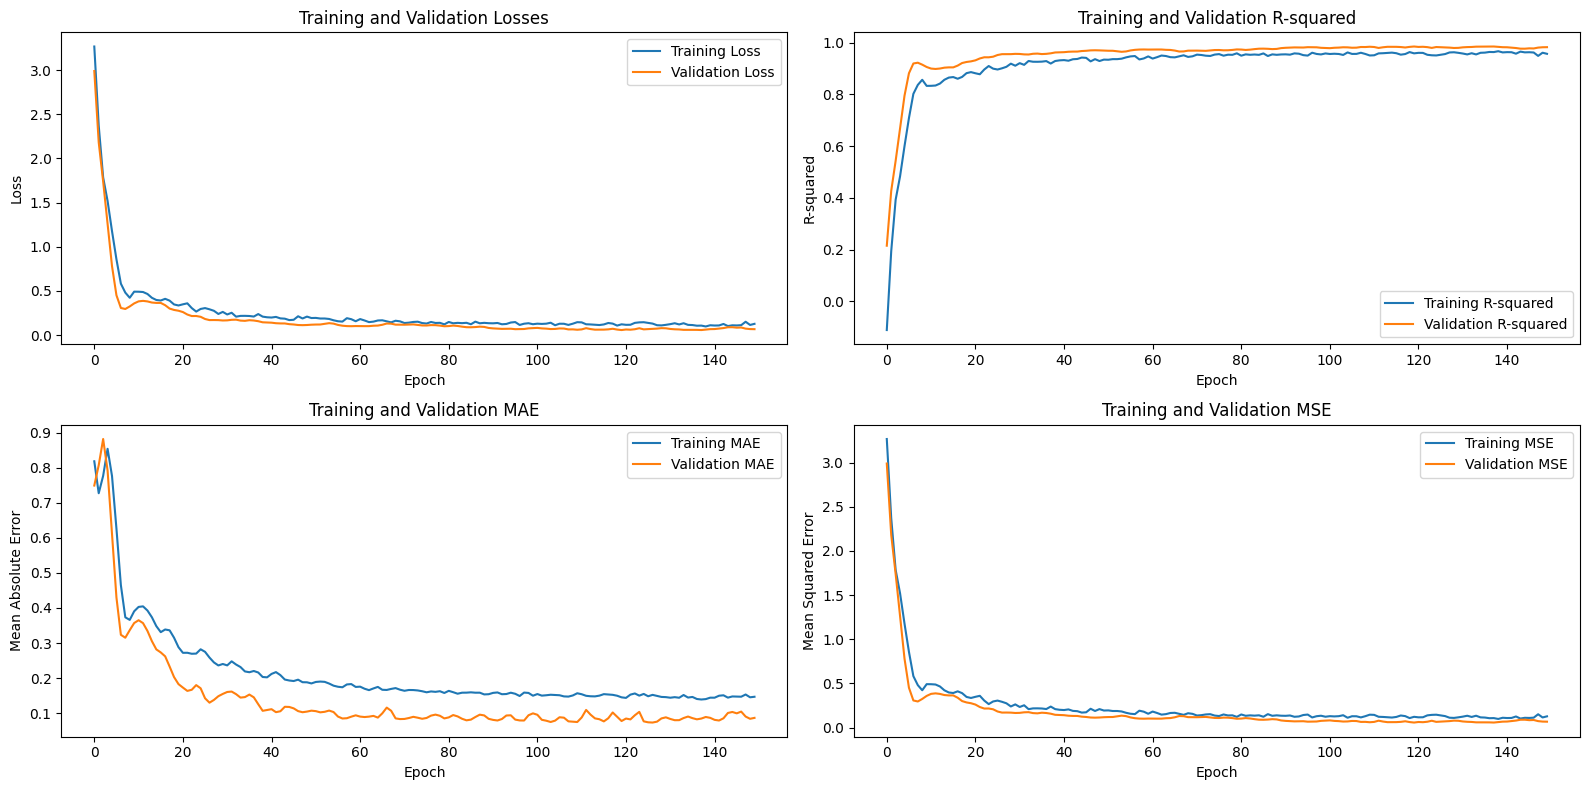

Test R-squared: 0.9783751088520247, Test MAE: 8.291412353515625, Test MSE: 502.5183410644531, Avg Test Residual: 2.6711618900299072


In [40]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_PARIS.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_PARIS.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_PARIS.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.0712185800075531, Test R-squared: 0.9783751088520247, Test MAE: 8.291412353515625, Test MSE: 502.5183410644531


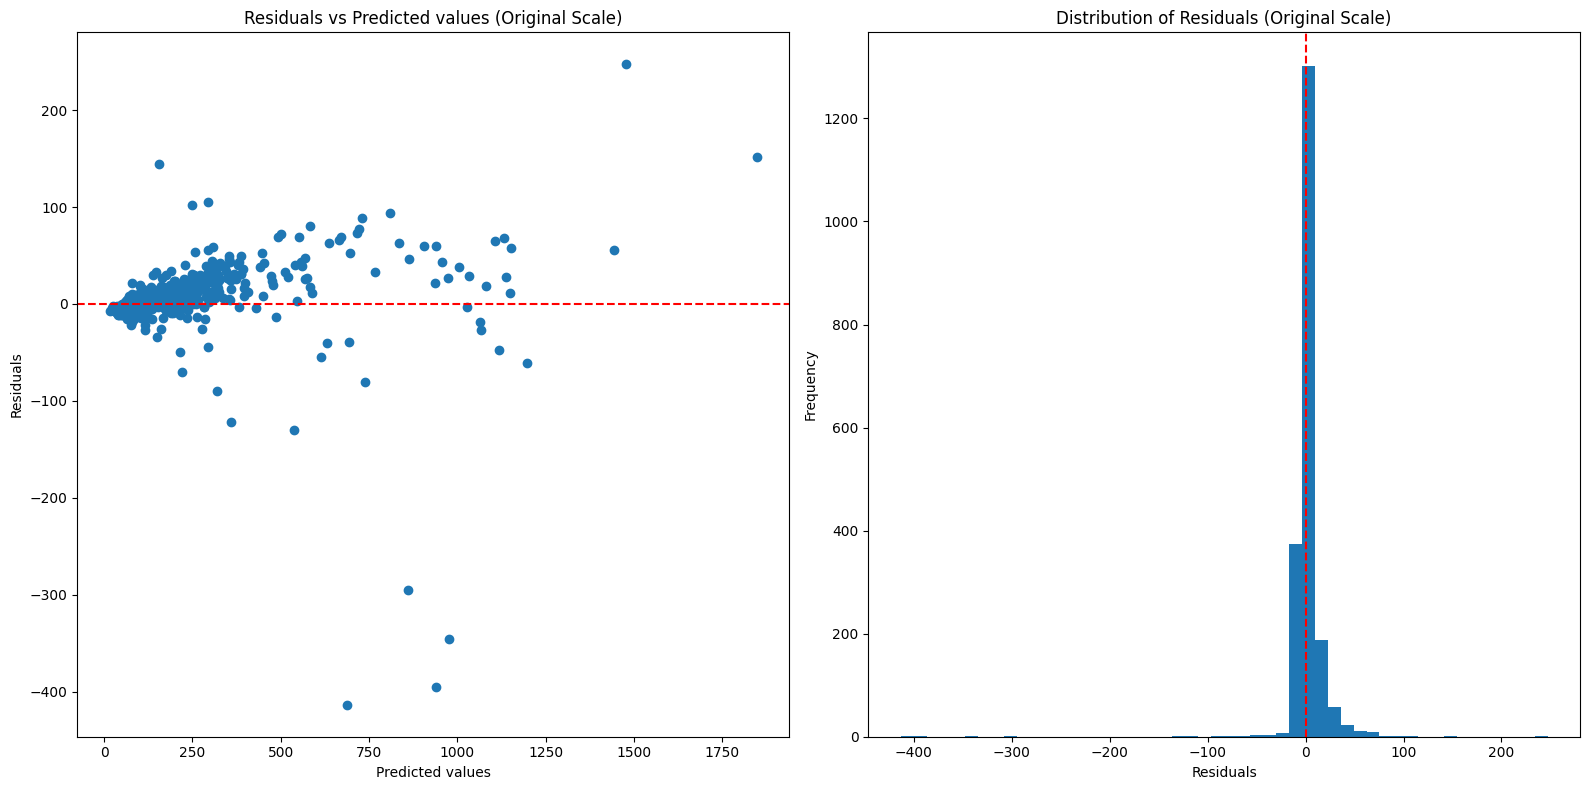

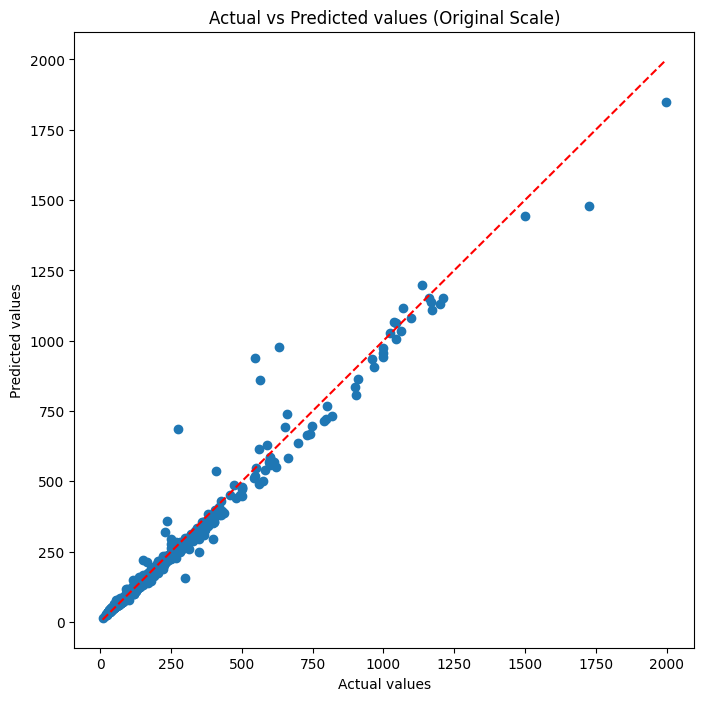

In [41]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

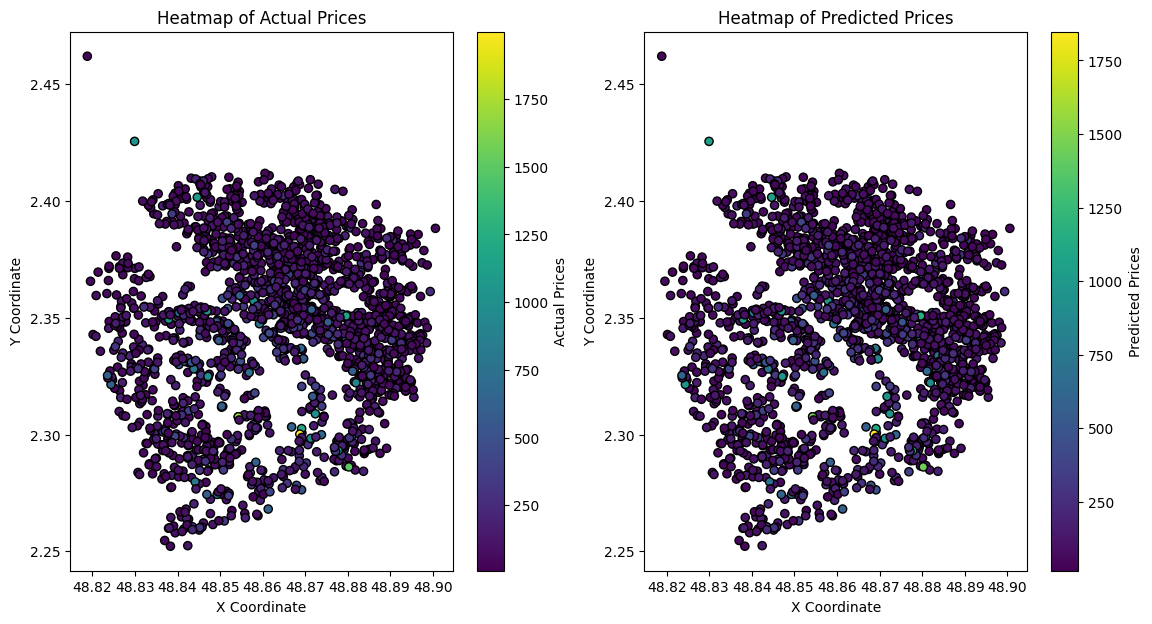

In [42]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


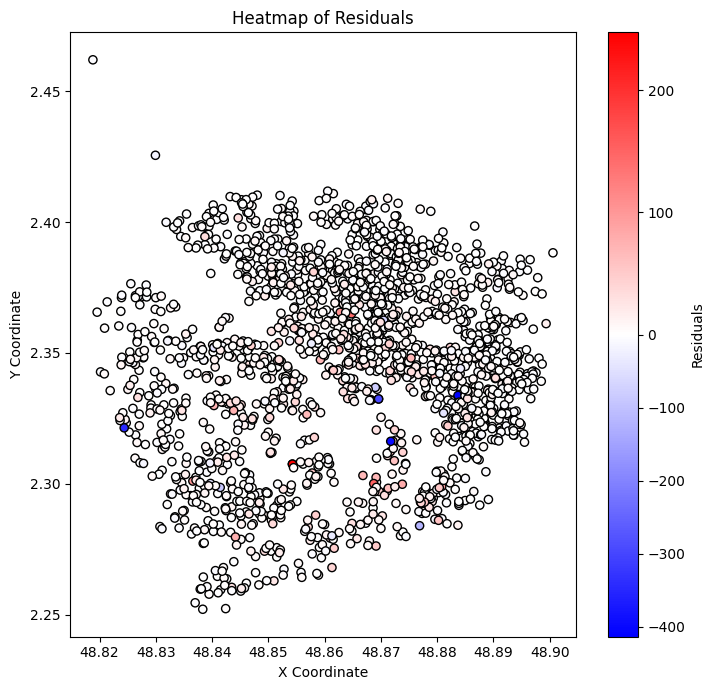

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


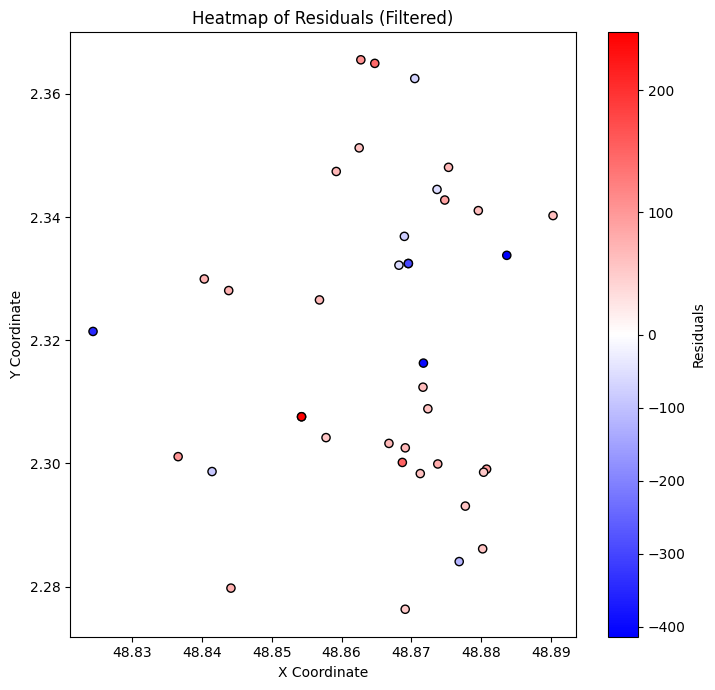

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


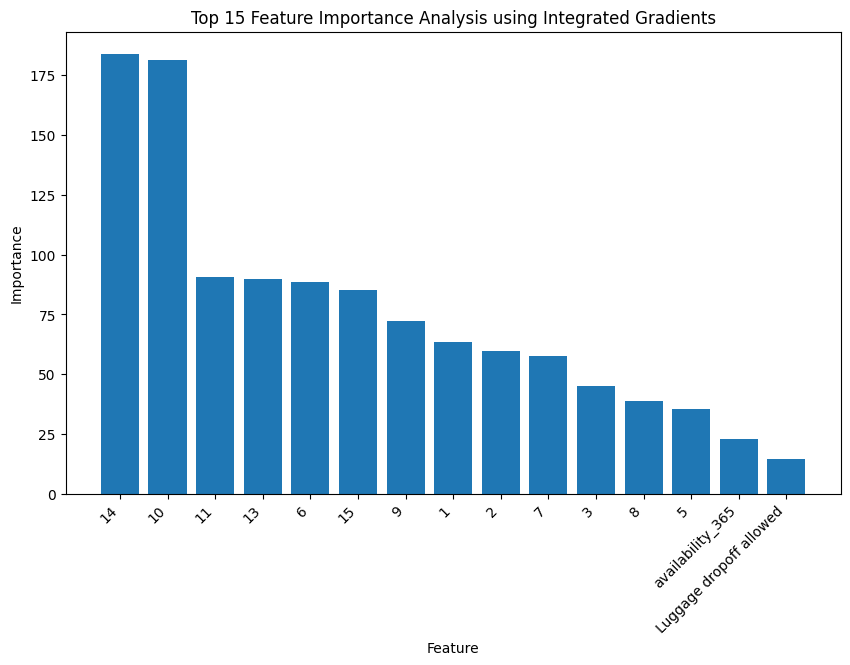

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


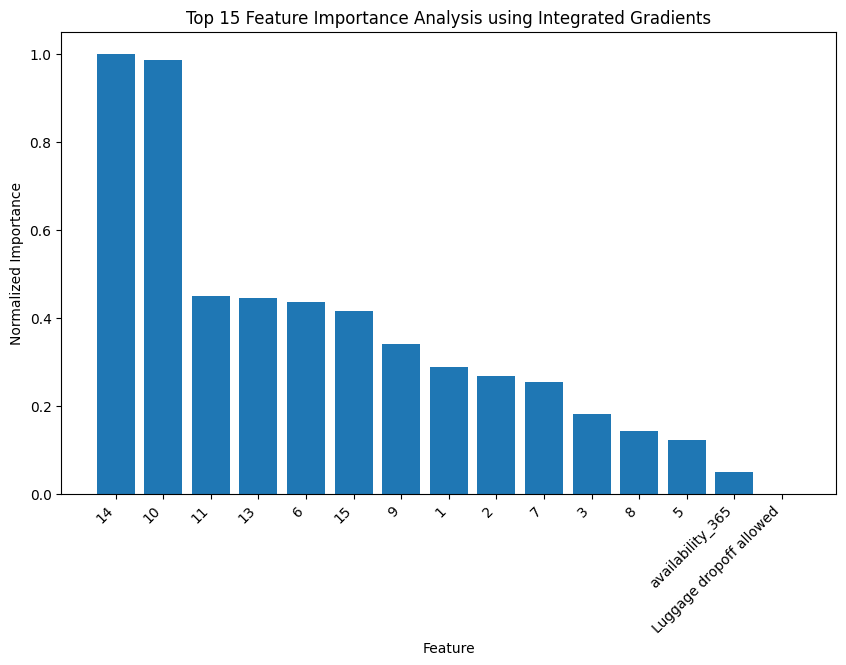

Top 15 Feature Importances (Normalized):
14: 1.0000
10: 0.9858
11: 0.4489
13: 0.4453
6: 0.4361
15: 0.4162
9: 0.3408
1: 0.2891
2: 0.2671
7: 0.2542
3: 0.1814
8: 0.1435
5: 0.1224
availability_365: 0.0490
Luggage dropoff allowed: 0.0000


In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")